Ноутбук должен запускаться из директории, содержащей read_data.py, svd.py, eval_metrics.py .

Создает два csv для каждого кластера, один с set_id, другой с user_id 

In [1]:
from read_data import read_data, train_test, user_item_matrix
from svd import Recommender, MostPopularRecommender, filter_new, convert_to_recsys_data
from eval_metrics import top_n, apk
import numpy as np
import seaborn as sns
from pandas.tseries.offsets import *
from pandas.compat import u
import csv
%matplotlib inline

/home/akis/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Читаем тренировочные и тестовые данные. Тестовые данные - последний месяц. Активными считаются сеты, которые продаались хотя бы один раз за месяц до начала теста. До разбиения проводится отождествление наследников, выкидываются бесплатные наборы.

In [2]:
train, test = train_test(read_data("../../input/", filename="orders_items_registrations.csv"), test_size=DateOffset(months=0, days=1),  sales_end_offset=DateOffset(months=0, days=7))

Active sets: 42
Test size: 85 Train size 15044


Удаляем из тестового датасета пользователей, не встречающихся в тренировочном

In [3]:
test = filter_new(train, test)

Users: 6410


Конвертируем датафреймы в формат, понимаемый recsys. Так же сохраняем user_idы пользователей.

In [4]:
user_ids = train["user_id"].unique()
train = convert_to_recsys_data(train)
test = convert_to_recsys_data(test)

Оцениваем эффективность рекомендаций для разных k и пропорций сетов из свд и топа в рекомендации. 

[0.10256410256410256, 0.5384615384615384, 0.5641025641025641, 0.4358974358974359, 0.4358974358974359, 0.4358974358974359, 0.5128205128205128, 0.48717948717948717, 0.5384615384615384]


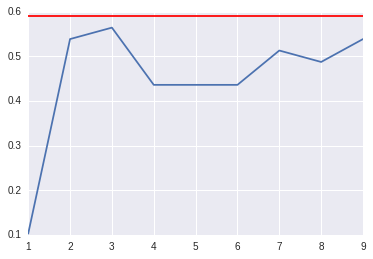

In [5]:
k_list = list(range(1, 10))
acc = []
most_pop = []
mrec = MostPopularRecommender(train, count=6)
for k in k_list:
    rec = Recommender(data=train, k=k, most_pop_count=12) # most_pop_count - length of inner list of most popular items
    acc.append(rec.eval_on_clusters(test, from_svd=4, from_top=2, metric=top_n))
print(acc)
sns.plt.plot(k_list, acc)
sns.plt.plot(k_list, [mrec.evaluate(test, metric=top_n) for i in k_list], color="r")
sns.plt.show()

Создаем svd-рекомендатор с заданным числом сегментов.

In [6]:
rec = Recommender(train, k=6, most_pop_count=12)

Получаем dict вида {cluster_id: {"set_ids":[], "user_ids": []}}

In [7]:
cluster_dict = rec.top_svd_mixed_clusters(from_svd=4, from_top=2)

Записываем его в csvшки

In [8]:
for cluster in cluster_dict:
    with open('output/' + 'svd_users_' + str(cluster) + '.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(["user_id"])
        for user_id in cluster_dict[cluster]["user_ids"]:
            writer.writerow([user_id])

    with open('output/' + 'svd_sets_' + str(cluster) + '.csv', 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(["set_id"])
        for set_id in cluster_dict[cluster]["set_ids"]:
            writer.writerow([set_id])

Содержимое кластеров сетов:

In [9]:
train, test = train_test(read_data("../../input/"), test_size=DateOffset(months=0, days=1),  sales_end_offset=DateOffset(months=0, days=7))
test = filter_new(train, test)
train = convert_to_recsys_data(train)
test = convert_to_recsys_data(test)
rec = Recommender(train, k=6, most_pop_count=12)

clusters = rec.top_svd_mixed_clusters(from_svd=4, from_top=2)
train, test = train_test(read_data("../../input/"), test_size=DateOffset(months=0, days=1),  sales_end_offset=DateOffset(months=0, days=7))
id_names = {}
for cluster in clusters:
    print clusters[cluster]["set_ids"]
    id_names[cluster] = []
    for row in train.iterrows():
        if row[1]["set_id"] in clusters[cluster]["set_ids"] and row[1]["set_title"] not in id_names[cluster]:
            id_names[cluster].append(row[1]["set_title"].split(" v.")[0].strip())
            clusters[cluster]["set_ids"].pop(clusters[cluster]["set_ids"].index(row[1]["set_id"]))
id_names = {i: list(set(id_names[i])) for i in id_names}
    
    
for i in clusters:
    print u'[' + u','.join(id_names[i]) + u']'

Active sets: 42
Test size: 85 Train size 15044
Users: 6410
Active sets: 42
Test size: 85 Train size 15044
[540, 520, 519, 521, 526, 527]
[513, 547, 451, 549, 526, 527]
[526, 540, 519, 520, 527, 549]
[513, 547, 535, 514, 526, 527]
[533, 273, 535, 545, 526, 527]
[535, 533, 514, 515, 526, 527]
[Mixed Starter,Пятничный красный,Red Starter,Дачный сет,Пятничный белый,Пятничный игристый]
[Mixed Starter,Red Explorer,Red Advanced,Red Starter,Meat the Wine,Ящик Barista Pinotage]
[Mixed Starter,Пятничный красный,Red Starter,Дачный сет,Пятничный белый,Meat the Wine]
[Mixed Starter,Red Explorer,Red Advanced,White Explorer,White Starter,Red Starter]
[Mixed Starter,White Starter,Red Starter,Drink Pink,Теплый клетчатый сет,Summer Set]
[Mixed Explorer,Mixed Starter,White Explorer,White Starter,Red Starter,Summer Set]
